### 11) Alex - QUBO

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch

import dimod
from neal.sampler import SimulatedAnnealingSampler

plt.style.use('dark_background')

dimod.serialization.format.set_printoptions(width=110, depth=10)

In [2]:
# Spin encoding

def binary_to_spin(binary):    
    return binary * 2 - 1

def spin_to_binary(spin):    
    return (spin + 1) // 2


# Bit encoding

def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)
    
    # print("number_bytes:", number_bytes)
    # print("integer_view:", integer_view)
    # print("bits_vector:", bits_vector)
    # print("bits:", bits)    
    
    return bits

def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)

    # print("bits:", bits)  
    # print("bits_vector:", bits_vector)
    # print("integer_view:", integer_view)
    # print("output:", output)
    
    return output


# One Hot encoding

def integer_to_one_hot(integer, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    number_bytes = np.array([integer], dtype=dtype)

    integer_view = number_bytes.view('uint8')
    
    bits = np.unpackbits(integer_view)
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


def one_hot_to_integer(one_hot_bits, dtype='>i1', one_hot_scheme=None):    
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    decoding_scheme = {value: key for key, value in one_hot_scheme.items()}
    
    bits = []
        
    for one_hot_pair in one_hot_bits.reshape(-1, 2):
        
        bit = decoding_scheme[tuple(one_hot_pair)]
        
        bits.append(bit)
        
    bits_array = np.array(bits, dtype=dtype)    
   
    return bits_array


def bits_to_one_hot(bits, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


# Coupling coefficients

def get_coupling_coefficients(coupling_matrix):
    
    '''Convert matrix of Coupling coefficients to dictionary of weights'''
    
    coupling_coefficients = dict()
    
    for row_index, row in enumerate(coupling_matrix):
        
        # print(row[row_index:])
        
        for column_index, cell in enumerate(row[row_index:], row_index):
            
            coupling_coefficients[row_index, column_index] = cell
            
    return coupling_coefficients


# Correct One Hot

def is_correct_one_hot(record, one_hot_scheme=None):
    
    sample = record.sample
    
    fields_spins = np.array(list(sample.values()))
    
    fields_one_hot = spin_to_binary(fields_spins)
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    for one_hot_pair in fields_one_hot.reshape(-1, 2):
        
        one_hot_tuple = tuple(one_hot_pair)
        
        if one_hot_tuple not in one_hot_scheme.values():            
            
            return False
    
    return True


# Sample to Value

def sample_to_value(sample):    

    fields_spins = np.array(list(sample.values()))

    fields_one_hot = spin_to_binary(fields_spins)

    fields_bits = one_hot_to_integer(fields_one_hot)

    fixed_part = fields_bits[FIXED_BITS_COUNT:]

    value = decode_from_bits(fixed_part)
    
    # print("fields_spins:", fields_spins)
    # print("fields_one_hot:", fields_one_hot, fields_one_hot.shape)
    # print("fields_bits:", fields_bits, fields_bits.shape)
    # print("fixed_part:", fixed_part, fixed_part.shape)

    return value

In [3]:
# 1) Input parameters

EXAMPLE_INITIAL_STOCK_PRICE = 105
EXAMPLE_VOLATILITY = 0.3

FIXED_BITS_COUNT = 32 + 8
VARIABLE_BITS_COUNT = 32

PENALTY_VALUE = 1.9

MAXIMIZE = True


fixed_one_hot_bits_count = FIXED_BITS_COUNT * 2
variable_one_hot_bits_count = VARIABLE_BITS_COUNT * 2

total_one_hot_bits_count = fixed_one_hot_bits_count + variable_one_hot_bits_count

example_volatility_percent = EXAMPLE_VOLATILITY * 100

In [4]:
# 2) Load weights

MODEL_PATH = 'saved_models/alex_no_linear_model.pt'

state_dict = torch.load(MODEL_PATH)

loaded_factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()

loaded_factorization_matrix.shape

loaded_factorization_matrix.min()

-0.29051444

In [5]:
# 3) Penalty matrix

    
# Example input penalty

encoded_initial_stock_price = encode_to_bits(EXAMPLE_INITIAL_STOCK_PRICE, 
                                             dtype='>f', bits_count=32)

encoded_volatility = encode_to_bits(example_volatility_percent, 
                                    dtype='i1', bits_count=8)

example_input = np.hstack((encoded_initial_stock_price, encoded_volatility)).squeeze()

one_hot_fields = bits_to_one_hot(example_input)

fixed_part_vector = -1 * binary_to_spin(one_hot_fields) * PENALTY_VALUE

variable_part_vector = np.zeros(variable_one_hot_bits_count, dtype=int)

example_input_penalty_vector = np.concatenate((fixed_part_vector, variable_part_vector))

penalty_matrix = np.diag(example_input_penalty_vector)


# One hot penalty

one_hot_pair_penalty = [[-PENALTY_VALUE, 2 * PENALTY_VALUE],
                        [2 * PENALTY_VALUE, -PENALTY_VALUE]]

one_hot_pairs_count = VARIABLE_BITS_COUNT // 2

for offset in range(fixed_one_hot_bits_count, total_one_hot_bits_count, 2):  
    
    penalty_matrix[offset : offset + 2,
                        offset : offset + 2] += one_hot_pair_penalty

# Printouts

print("example_input:\n", example_input)
print("one_hot_fields:\n", one_hot_fields)
print("example_input_penalty_vector:\n", example_input_penalty_vector)
print("penalty_matrix part:\n", penalty_matrix[: , :])

example_input:
 [0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 0]
one_hot_fields:
 [0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0
 1 0 1 0 0 1]
example_input_penalty_vector:
 [ 1.9 -1.9 -1.9  1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9 -1.9  1.9
  1.9 -1.9 -1.9  1.9 -1.9  1.9  1.9 -1.9 -1.9  1.9  1.9 -1.9  1.9 -1.9
 -1.9  1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9
  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9
  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9
 -1.9  1.9 -1.9  1.9 -1.9  1.9 -1.9  1.9  1.9 -1.9  0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

In [6]:
# 4) QUBO

factorization_matrix = loaded_factorization_matrix

coupling_matrix = factorization_matrix @ factorization_matrix.T

if MAXIMIZE:
    
    coupling_matrix = -coupling_matrix

penalized_coupling_matrix = coupling_matrix + penalty_matrix

qubo_coefficients = get_coupling_coefficients(penalized_coupling_matrix) 

sampler = SimulatedAnnealingSampler()


# Printouts

print("factorization_matrix:\n", factorization_matrix.shape)
print("coupling_matrix:\n", coupling_matrix.shape)
print("penalized_coupling_matrix part:\n", penalized_coupling_matrix[-3:, -3:])
print("qubo_coefficients part:\n", qubo_coefficients.__repr__()[-60:])

factorization_matrix:
 (144, 144)
coupling_matrix:
 (144, 144)
penalized_coupling_matrix part:
 [[-2.75750604 -0.06120287 -0.15436158]
 [-0.06120287 -3.00893607  3.96995297]
 [-0.15436158  3.96995297 -2.7878147 ]]
qubo_coefficients part:
 2, 143): 3.9699529737234114, (143, 143): -2.787814700603485}


In [7]:
# 5) Run

shots_count = 1000

results = sampler.sample_qubo(Q=qubo_coefficients, num_reads=shots_count)

aggregated_results = results.aggregate()

filtered_results = aggregated_results.filter(pred=is_correct_one_hot)

print("results:", len(results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

results: 1000
aggregated_results: 679
filtered_results: 2


In [8]:
print(results)

     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 ... 143      energy num_oc.
85   0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  1  1  1  0  0  1 ...   0 -180.972615       1
488  0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  1  1  1  0  0  1 ...   0 -180.972615       1
735  0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  1  1  1  0  0  1 ...   0 -180.972615       1
171  0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  0  1  1  0  0  1 ...   0 -180.945375       1
378  0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  0  1  1  0  0  1 ...   0 -180.945375       1
923  0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  0  1  1  0  0  1 ...   0 -180.945375       1
992  0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  0  1  1  0  0  1 ...   0 -180.945375       1
451  0  1  1  0  0  1  0  1  0  1  0  1  1  0  1  1  1  0  1  0  0  1  1  0  0  1 ...   0 -180.892274       1
...
344  0

In [9]:
# 5) Top Option Prices

top_record = filtered_results.first

top_sample = top_record.sample

top_asset_price = sample_to_value(top_sample)


top_samples = filtered_results.samples(n=10)

top_asset_prices = []

for top_sample in top_samples:
    
    top_value = sample_to_value(top_sample)
    
    top_asset_prices.append(top_value.item())
    
top_asset_prices = np.array(top_asset_prices)


print("Example initial stock price:", EXAMPLE_INITIAL_STOCK_PRICE)
print("Example volatility:", EXAMPLE_VOLATILITY)
print("example_volatility_percent:", example_volatility_percent)
print("Task:", ['Minimize', 'Maximize'][MAXIMIZE])
print("Top asset price:", top_asset_price)
print("Top asset prices:", top_asset_prices)

Example initial stock price: 105
Example volatility: 0.3
example_volatility_percent: 30.0
Task: Maximize
Top asset price: [-0.00282613]
Top asset prices: [-2.82613304e-03 -2.46180525e+38]


### 12) Alex - QUBO Energies

In [10]:
DATASET_PATH = 'simulated_prices/alex_dataset.csv'

PENALIZED = False


data = pd.read_csv(DATASET_PATH)

encoded_initial_asset_prices = encode_to_bits(data.initial_asset_price, 
                                              dtype='>f', bits_count=32)

volatility_percents = data.volatility * 100

encoded_volatility_percents = encode_to_bits(volatility_percents,
                                             dtype='i1', bits_count=8)

encoded_asset_prices = encode_to_bits(data.asset_price, 
                                      dtype='>f', bits_count=32)

encoded_dataset_array = np.hstack((encoded_initial_asset_prices,
                                   encoded_volatility_percents,
                                   encoded_asset_prices))

encoded_dataset_array.shape


energies = []

for row_bits in encoded_dataset_array:  
    
    one_hot_row = bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))
    
    if PENALIZED:
        
        energy = dimod.utilities.qubo_energy(sample=sample, Q=qubo_coefficients)        
    
    else:

        qubo_coefficients = get_coupling_coefficients(coupling_matrix) 

        energy = dimod.utilities.qubo_energy(sample=sample, Q=qubo_coefficients)
    
    energies.append(energy)

In [11]:
# Import predictions

PREDICTIONS_PATH = 'predictions/alex_no_linear_predictions.xlsx'

predictions_dataframe = pd.read_excel(PREDICTIONS_PATH)

targets = predictions_dataframe['Targets']
predictions = predictions_dataframe['Predictions']

targets

0      0.000000
1      0.000000
2      0.000000
3      0.000001
4      0.000000
         ...   
995    0.000000
996    0.000000
997    0.000000
998    0.000000
999    0.000000
Name: Targets, Length: 1000, dtype: float64

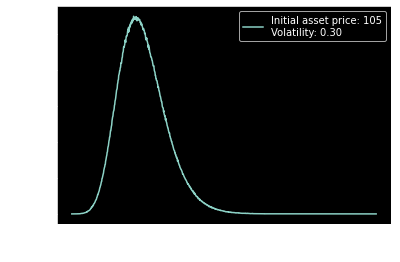

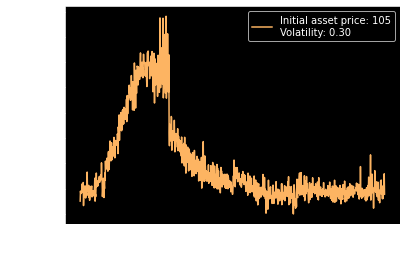

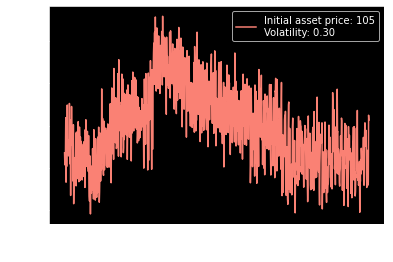

In [12]:
slice_size = 1000
slices_count = len(data) // slice_size

slice_indices = range(0, 1)


for slice_index in slice_indices:

    data_slice = slice(slice_index * slice_size, 
                       slice_index * slice_size + slice_size)

    label = f"Initial asset price: {data.initial_asset_price[data_slice].mean():.00f}\n" \
            f"Volatility: {data.volatility[data_slice].mean():.02f}"

    plt.plot(data.asset_price[data_slice], data.probability[data_slice], label=label)

    plt.xlabel("Asset price")
    plt.ylabel("Monte-Carlo Probability")
    plt.legend()
    plt.show()
    
    plt.plot(data.asset_price[data_slice], predictions[data_slice], label=label, color='#fdb462')

    plt.xlabel("Asset price")
    plt.ylabel("Predicited Probability")
    plt.legend()
    plt.show()
    
    plt.plot(data.asset_price[data_slice], energies[data_slice], label=label, color='#fa8174')
    
    plt.gca().invert_yaxis()

    plt.xlabel("Asset price")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

### 9) Alex - Ising

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch

import dimod
from neal.sampler import SimulatedAnnealingSampler

plt.style.use('dark_background')

dimod.serialization.format.set_printoptions(width=110, depth=20)

In [2]:
# Spin encoding

def binary_to_spin(binary):    
    return binary * 2 - 1

def spin_to_binary(spin):    
    return (spin + 1) // 2


# Bit encoding

def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)
    
    # print("number_bytes:", number_bytes)
    # print("integer_view:", integer_view)
    # print("bits_vector:", bits_vector)
    # print("bits:", bits)    
    
    return bits

def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)

    # print("bits:", bits)  
    # print("bits_vector:", bits_vector)
    # print("integer_view:", integer_view)
    # print("output:", output)
    
    return output


# One Hot encoding

def integer_to_one_hot(integer, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    number_bytes = np.array([integer], dtype=dtype)

    integer_view = number_bytes.view('uint8')
    
    bits = np.unpackbits(integer_view)
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


def one_hot_to_integer(one_hot_bits, dtype='>i1', one_hot_scheme=None):    
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    decoding_scheme = {value: key for key, value in one_hot_scheme.items()}
    
    bits = []
        
    for one_hot_pair in one_hot_bits.reshape(-1, 2):
        
        bit = decoding_scheme[tuple(one_hot_pair)]
        
        bits.append(bit)
        
    bits_array = np.array(bits, dtype=dtype)    
   
    return bits_array


def bits_to_one_hot(bits, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


# Coupling coefficients

def get_coupling_coefficients(coupling_matrix):
    
    '''Convert matrix of Coupling coefficients to dictionary of weights'''
    
    coupling_coefficients = dict()
    
    for row_index, row in enumerate(coupling_matrix):
        
        # print(row[row_index:])
        
        for column_index, cell in enumerate(row[row_index:], row_index):
            
            coupling_coefficients[row_index, column_index] = cell
            
    return coupling_coefficients


# Correct One Hot

def is_correct_one_hot(record, one_hot_scheme=None):
    
    sample = record.sample
    
    fields_spins = np.array(list(sample.values()))
    
    fields_one_hot = spin_to_binary(fields_spins)
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    for one_hot_pair in fields_one_hot.reshape(-1, 2):
        
        one_hot_tuple = tuple(one_hot_pair)
        
        if one_hot_tuple not in one_hot_scheme.values():            
            
            return False
    
    return True


# Sample to Value

def sample_to_value(sample):    

    fields_spins = np.array(list(sample.values()))

    fields_one_hot = spin_to_binary(fields_spins)

    fields_bits = one_hot_to_integer(fields_one_hot)

    fixed_part = fields_bits[FIXED_BITS_COUNT:]

    value = decode_from_bits(fixed_part)
    
    # print("fields_spins:", fields_spins)
    # print("fields_one_hot:", fields_one_hot, fields_one_hot.shape)
    # print("fields_bits:", fields_bits, fields_bits.shape)
    # print("fixed_part:", fixed_part, fixed_part.shape)

    return value

In [3]:
# 1) Input parameters

EXAMPLE_INITIAL_STOCK_PRICE = 105
EXAMPLE_VOLATILITY = 0.3

FIXED_BITS_COUNT = 32 + 8
VARIABLE_BITS_COUNT = 32

PENALTY_VALUE = 1.2

MAXIMIZE = True


fixed_one_hot_bits_count = FIXED_BITS_COUNT * 2
variable_one_hot_bits_count = VARIABLE_BITS_COUNT * 2

total_one_hot_bits_count = fixed_one_hot_bits_count + variable_one_hot_bits_count

example_volatility_percent = EXAMPLE_VOLATILITY * 100

In [4]:
# 2) Load weights

MODEL_PATH = 'saved_models/alex_model.pt'

state_dict = torch.load(MODEL_PATH)

loaded_factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()
loaded_component_weights = state_dict['linear.fc.weight'].numpy().squeeze()
loaded_global_bias = state_dict['linear.bias'].numpy().squeeze()

loaded_factorization_matrix.shape, loaded_component_weights.shape, loaded_global_bias.shape

((144, 144), (144,), ())

In [5]:
# 3) Variable fields penalty

one_hot_pair_penalty = [[-PENALTY_VALUE, 2 * PENALTY_VALUE],
                        [2 * PENALTY_VALUE, -PENALTY_VALUE]]

penalization_matrix = np.zeros((total_one_hot_bits_count, total_one_hot_bits_count), dtype=int)

one_hot_pairs_count = VARIABLE_BITS_COUNT // 2

for offset in range(fixed_one_hot_bits_count, total_one_hot_bits_count, 2):  
    
    penalization_matrix[offset : offset + 2,
                        offset : offset + 2] = one_hot_pair_penalty
    
print("penalization_matrix part:\n", penalization_matrix[-4:, -4:])

penalization_matrix part:
 [[-1  2  0  0]
 [ 2 -1  0  0]
 [ 0  0 -1  2]
 [ 0  0  2 -1]]


In [6]:
# 4) Fixed fields penalty

encoded_initial_stock_price = encode_to_bits(EXAMPLE_INITIAL_STOCK_PRICE, 
                                             dtype='>f', bits_count=32)

encoded_volatility = encode_to_bits(example_volatility_percent, 
                                    dtype='i1', bits_count=8)

example_input = np.hstack((encoded_initial_stock_price, encoded_volatility)).squeeze()

one_hot_fields = bits_to_one_hot(example_input)

fixed_part_vector = -1 * binary_to_spin(one_hot_fields) * PENALTY_VALUE

variable_part_vector = np.zeros(variable_one_hot_bits_count, dtype=int)

penalization_vector = np.concatenate((fixed_part_vector, variable_part_vector))

print("example_input:\n", example_input)
print("one_hot_fields:\n", one_hot_fields)
print("penalization_vector:\n", penalization_vector)

example_input:
 [0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 0]
one_hot_fields:
 [0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0
 1 0 1 0 0 1]
penalization_vector:
 [ 1.2 -1.2 -1.2  1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2 -1.2  1.2
  1.2 -1.2 -1.2  1.2 -1.2  1.2  1.2 -1.2 -1.2  1.2  1.2 -1.2  1.2 -1.2
 -1.2  1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2
  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2
  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2
 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2  1.2 -1.2  0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

In [7]:
# 5) Quadratic

factorization_matrix = loaded_factorization_matrix

coupling_matrix = factorization_matrix @ factorization_matrix.T

if MAXIMIZE:
    
    coupling_matrix = -coupling_matrix

penalized_coupling_matrix = coupling_matrix + penalization_matrix

coupling_coefficients = get_coupling_coefficients(penalized_coupling_matrix) 


# Printouts

print("factorization_matrix:\n", factorization_matrix.shape)
print("coupling_matrix:\n", coupling_matrix.shape)
print("penalized_coupling_matrix part:\n", penalized_coupling_matrix[-3:, -3:])
print("coupling_coefficients part:\n", coupling_coefficients.__repr__()[-60:])

factorization_matrix:
 (144, 144)
coupling_matrix:
 (144, 144)
penalized_coupling_matrix part:
 [[-2.02679992 -0.0200645   0.07133943]
 [-0.0200645  -1.93736643  1.98539879]
 [ 0.07133943  1.98539879 -1.94992298]]
coupling_coefficients part:
 , 143): 1.9853987907990813, (143, 143): -1.9499229788780212}


In [8]:
# 6) Linear

component_weights = loaded_component_weights

if MAXIMIZE:
    
    component_weights = -component_weights

penalized_component_weights = component_weights + penalization_vector

component_coefficients = dict(enumerate(penalized_component_weights))

print("component_weights.shape:\n", component_weights.shape)
print("penalization_vector:\n", penalization_vector)
print("penalized_component_weights.shape:\n", penalized_component_weights.shape)

component_weights.shape:
 (144,)
penalization_vector:
 [ 1.2 -1.2 -1.2  1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2 -1.2  1.2
  1.2 -1.2 -1.2  1.2 -1.2  1.2  1.2 -1.2 -1.2  1.2  1.2 -1.2  1.2 -1.2
 -1.2  1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2
  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2
  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2
 -1.2  1.2 -1.2  1.2 -1.2  1.2 -1.2  1.2  1.2 -1.2  0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0. ]
penalized_component_weights.shape:
 (144,)


In [9]:
# 7) Bias

global_bias = loaded_global_bias

if MAXIMIZE:
    
    global_bias = -global_bias
    
print("global_bias:\n", global_bias)

global_bias:
 -0.0022002105


In [10]:
# 8) BQM  

quadratic = coupling_coefficients

linear = component_coefficients

offset = global_bias

variable_type = dimod.SPIN

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, variable_type)

sampler = SimulatedAnnealingSampler()

# sampler = dimod.ExactSolver()

# qubo = dimod.utilities.ising_to_qubo(linear, quadratic, offset)

In [11]:
# 9) Run

shots_count = 10000

results = sampler.sample(model, num_reads=shots_count)

aggregated_results = results.aggregate()


# 10) Results

filtered_results = aggregated_results.filter(pred=is_correct_one_hot)

print("results:", len(results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

results: 10000
aggregated_results: 3464
filtered_results: 26


In [12]:
# 11) Top Option Prices

top_record = filtered_results.first

top_sample = top_record.sample

top_asset_price = sample_to_value(top_sample)


top_samples = filtered_results.samples(n=10)

top_asset_prices = []

for top_sample in top_samples:
    
    top_value = sample_to_value(top_sample)
    
    top_asset_prices.append(top_value.item())
    
top_asset_prices = np.array(top_asset_prices)


print("Example initial stock price:", EXAMPLE_INITIAL_STOCK_PRICE)
print("Example volatility:", EXAMPLE_VOLATILITY)
print("example_volatility_percent:", example_volatility_percent)
print("Task:", ['Minimize', 'Maximize'][MAXIMIZE])
print("Top asset price:", top_asset_price)
print("Top asset prices:", top_asset_prices)

Example initial stock price: 105
Example volatility: 0.3
example_volatility_percent: 30.0
Task: Maximize
Top asset price: [2.461694e+09]
Top asset prices: [2.46169395e+09 7.23427134e-30 3.10709491e-20 7.24659730e-30
 7.23426909e-30 3.12827074e-20 3.11239016e-20 7.22810837e-30
 2.46588928e+09 4.52141959e-31]


### 10) Alex - Ising Energies

In [13]:
DATASET_PATH = 'simulated_prices/alex_dataset.csv'

PENALIZED = False


data = pd.read_csv(DATASET_PATH)

encoded_initial_asset_prices = encode_to_bits(data.initial_asset_price, 
                                              dtype='>f', bits_count=32)

volatility_percents = data.volatility * 100

encoded_volatility_percents = encode_to_bits(volatility_percents,
                                             dtype='i1', bits_count=8)

encoded_asset_prices = encode_to_bits(data.asset_price, 
                                      dtype='>f', bits_count=32)

encoded_dataset_array = np.hstack((encoded_initial_asset_prices,
                                   encoded_volatility_percents,
                                   encoded_asset_prices))

encoded_dataset_array.shape


energies = []

for row_bits in encoded_dataset_array:  
    
    one_hot_row = bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))
    
    if PENALIZED:
        
        energy = dimod.utilities.ising_energy(sample, h=linear, J=quadratic, offset=offset)        
    
    else:
        
        component_coefficients = dict(enumerate(component_weights))

        not_penalized_coupling_coefficients = get_coupling_coefficients(coupling_matrix) 

        energy = dimod.utilities.ising_energy(sample, 
                                              h=component_coefficients, 
                                              J=not_penalized_coupling_coefficients, 
                                              offset=offset)
    
    energies.append(energy)

In [15]:
# Import predictions

PREDICTIONS_PATH = 'predictions/alex_predictions.xlsx'

predictions_dataframe = pd.read_excel(PREDICTIONS_PATH)

targets = predictions_dataframe['Targets']
predictions = predictions_dataframe['Predictions']

targets

0      0.000000
1      0.000000
2      0.000000
3      0.000001
4      0.000000
         ...   
995    0.000000
996    0.000000
997    0.000000
998    0.000000
999    0.000000
Name: Targets, Length: 1000, dtype: float64

In [16]:
np.argmax(targets)

203

In [19]:
targets[203]

0.005495

In [18]:
targets.shape

(1000,)

In [ ]:
# 101.172077

In [25]:
np.argmax(-np.array(energies))

357

In [26]:
energies[357]

-35.64344

In [27]:
data.asset_price[357]

147.852484

In [28]:
data.probability[data_slice]

0      0.000000
1      0.000000
2      0.000000
3      0.000001
4      0.000000
         ...   
995    0.000000
996    0.000000
997    0.000000
998    0.000000
999    0.000000
Name: probability, Length: 1000, dtype: float64

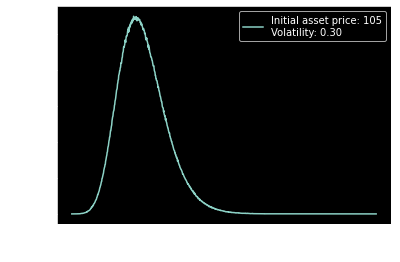

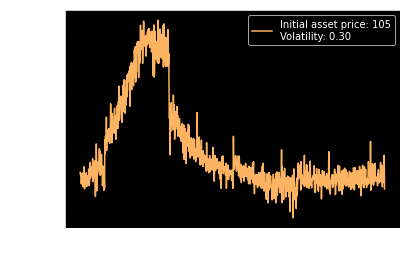

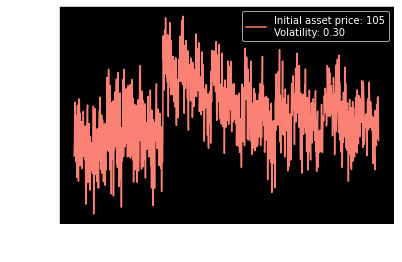

In [20]:
slice_size = 1000
slices_count = len(data) // slice_size

slice_indices = range(0, 1)


for slice_index in slice_indices:

    data_slice = slice(slice_index * slice_size, 
                       slice_index * slice_size + slice_size)

    label = f"Initial asset price: {data.initial_asset_price[data_slice].mean():.00f}\n" \
            f"Volatility: {data.volatility[data_slice].mean():.02f}"

    plt.plot(data.asset_price[data_slice], data.probability[data_slice], label=label)

    plt.xlabel("Asset price")
    plt.ylabel("Monte-Carlo Probability")
    plt.legend()
    plt.show()
    
    plt.plot(data.asset_price[data_slice], predictions[data_slice], label=label, color='#fdb462')

    plt.xlabel("Asset price")
    plt.ylabel("Predicited Probability")
    plt.legend()
    plt.show()
    
    plt.plot(data.asset_price[data_slice], energies[data_slice], label=label, color='#fa8174')
    
    plt.gca().invert_yaxis()

    plt.xlabel("Asset price")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

In [ ]:
# TODO: Latent factor
# Energy ising -> FM: mapping: literature

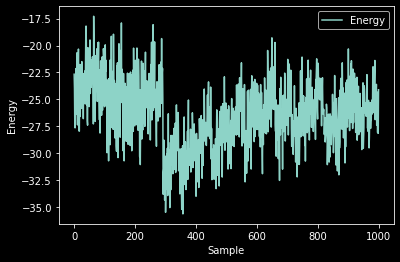

In [27]:
plt.plot(energies[-1000:], label="Energy")

plt.xlabel("Sample")
plt.ylabel("Energy")
plt.legend()
plt.show()